# 1. Setup

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds     # Import Tensorflow dataset that we will use
import numpy as np
import matplotlib.pyplot as plt
import functools
import os
import mitdeeplearning as mdl
from IPython import display as ipythondisplay
from tqdm import tqdm

tfds.disable_progress_bar()

In [2]:
# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
len(tf.config.list_physical_devices('GPU'))

1

# 2. Dataset Setup

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']
train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

See one review and the output label

Next shuffle the data for training and create batches of these (text, label) pairs:

In [4]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [5]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [6]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:2])
  print()
  print('labels: ', label.numpy()[:2])

texts:  [b"First of all, I firmly believe that Norwegian movies are continually getting better. From the tedious emotional films of the 70's and 80's, movies from this place actually started to contain a bit of humour. Imagine.. Actual comedies were made! Movies were actually starting to get entertaining and funny, as opposed to long, dark, depressing and boring.<br /><br />During the 90's and 00's several really great movies were made by a 'new generation' of filmmakers. Movie after movie were praised by critics and played loads of money. It became the norm!<br /><br />Then came United...<br /><br />*MINOR SPOILERS* It's just simply not funny. Not once. Not ever. But the thing is... We THINK its funny. Because we're used to norwegian movies to be funny. Especially with a cast like this with a few really funny comedians. But.. They neither say nor do anything funny! Where's the humor? Show me the humor! Is it the awkward clerk played by Harald Eia? Is it the overacting totally ridiculo

# 3. Encode / Vectorize the text

Capture all Reviews and Labels from the Dataset:

In [25]:
reviews = []
labels = []
for i, [review, label] in enumerate(train_dataset):
    for j in range(len(review)):
        reviews.append(review.numpy()[j].decode('utf-8').lower())
        labels.append(label.numpy()[j])

See one example of one specific Review and the corresponde Label:

In [26]:
print(reviews[22000])
print(labels[22000])

giant crabs cursing in japanese? what was in that drink? a terrible movie, but laughable. i love the invisible samurai ghosties running around. drink much beer before you see this movie.
0


Create a function that encode the text to a list of words:

In [27]:
def vectorized_text(text):
    words = text.split()                                           # Split into words
    words = [word.strip('.,!;()''[]"#&%*@/£$') for word in words]  # Remove punctuation marks
    words = [word.replace("'s", '') for word in words]             # Remove 's
    return words

Apply the function to all Reviews and create a nester list that eache row contains one list of words that each review: 

In [28]:
words = []
for i, review in enumerate(reviews):
    words.append(vectorized_text(review))

See one example:

In [29]:
print(words[22000])

['giant', 'crabs', 'cursing', 'in', 'japanese?', 'what', 'was', 'in', 'that', 'drink?', 'a', 'terrible', 'movie', 'but', 'laughable', 'i', 'love', 'the', 'invisible', 'samurai', 'ghosties', 'running', 'around', 'drink', 'much', 'beer', 'before', 'you', 'see', 'this', 'movie']


Now lets convert to one only list the words nester list:

In [30]:
flat_words = []
for elem in words:
    flat_words.extend(elem)

Create a function that allows us create one dictionary of all unique words presents on dataset:

In [31]:
def unique_words(words):
    unique_words_dict = {}
    u_words = list(set(words))
    u_words.sort()
    for i, word in enumerate(u_words):
        unique_words_dict.update({word: i})
    return unique_words_dict

Apply the function:

In [32]:
unique_words_dict = unique_words(flat_words)

See how many unique words we have in our dataset:

In [33]:
print(len(unique_words_dict))

147916


Show the first pairs of key and values of our Dictionary of unique words:

In [34]:
count = 0
for review, label in unique_words_dict.items():
    print(review, label)
    count += 1
    if count % 20 == 0:
        break

 0
a 1
own 2
' 3
'' 4
''<br 5
''a 6
''after 7
''bad 8
''cannibal 9
''clients'' 10
''dark'' 11
''empire 12
''family 13
''gaslight'' 14
''heart'' 15
''high 16
''holy 17
''human'' 18
''humans'' 19


Create the `Encode Function`:

In [35]:
word2idx = {u:i for i, u in enumerate(unique_words_dict)}

Create the `Decoder Function`:

In [36]:
def idx2word(idx):
    key_list = list(unique_words_dict.keys())
    val_list = list(unique_words_dict.values())
    position = val_list.index(idx)
    return key_list[position]

Create the **Encoder Function** that will encode all words presents in the text:

In [37]:
def encode(words):
  encoded_output = np.array([word2idx[word] for word in words])
  return encoded_output

encoded_words = encode(flat_words)

Let's see one exemple of vectorized string:

In [39]:
print ('{} ---- characters mapped to int ----> {}'.format(repr(flat_words[:10]), encoded_words[:10]))
# check that vectorized_songs is a numpy array
assert isinstance(encoded_words, np.ndarray), "returned result should be a numpy array"

['three', 'stooges', '-', 'have', 'rocket', 'will', 'travel', '-', '1959', 'this'] ---- characters mapped to int ----> [132501 126058   3381  65636 113004 144177 135072   3381   4749 132157]


Compare the results to check if is all alright:

In [40]:
print(unique_words_dict['what'])
print(unique_words_dict['film'])
print(unique_words_dict['the'])

143400
55385
131388


# 4. Create training examples and targets

First we need to create a nester list for our reviews words already encoded:

In [41]:
reviews_encoded = []

for i in range(len(words)):
    reviews_encoded.append(encode(words[i]))

See one example:

In [42]:
print(reviews_encoded[22397])
print(labels[22397])
print("------------")
print(reviews_encoded[8278])
print(labels[8278])
print("------------")
print(len(reviews_encoded))

[125688  68029  13455  63316  58644  67172 116071  57297  13455 111820
  20400 131388  29735  81687 143548  67698 136385  28376 143270 143201
  88613 143599 131832  19343 131720  13455 111233  39159  71254 131388
 118938  95863  13455  84209  86114  13455  82292  95863 131388  60895
  58644  39159  58644 131388  25409  78654  71254 131388 144136  33486
 131388 112423 133019 133534 102033 131479  18775  96711  29550  96711
  13455  25026  49309 112611 133019  54839  21952  76505  85381  17537
 137580  87818  29056 119090 104656  52613  71254 143599  73955  16954
 118325  19937  13455 102609  95863 114572  58644 131388 131925  96544
 131388  25991 108363  76504  77836  89729 131231 119090 130669  16954
 127671 131388  82260  95863  13455  33168  29369 131720  18181  94888
 136408  90001  95863 131388  63316  65636  93718  70311  95863 132157
  39159  87692  76050  23275  89729  69532 131231 131832 109410  73955
  57635  70377  87692 119133 122907  80808  96544  13455  41935  96976
  9671

Now we must create a function that will help us find the `max columns` presents in one batch:

In [43]:
def max_columns(reviews_encoded):
    max_col = 0
    for i, k in enumerate(reviews_encoded):
        j = len(reviews_encoded[i])
        if j > max_col:
            max_col = j
    return max_col

Our next step is create a batch of training examples:

In [124]:
def get_batch(reviews_encoded, labels, batch_size):
    
    # the length of the vectorized songs string
    n = len(reviews_encoded)
    
    # randomly choose the starting indices for the examples in the training batch
    # choose in [0, n] range 'batch_size' numbers randomly
    idx = np.random.choice(n, batch_size)
    
    # List of input sequences for the training batch
    input_batch = []
    for i in idx:
        input_batch.append(reviews_encoded[i])
    
    # List of output sequences for the training output
    output_batch = []
    for i in idx:
        output_batch.append(labels[i])
    
    # Find the max columns on the input batch
    max_col = max_columns(input_batch)
    
    # Padding with the most frequently word ("the") to ensure the columns have the same size
    for i, j in enumerate(input_batch):
        input_batch[i] = np.pad(input_batch[i], (0, (max_col - len(input_batch[i]))), constant_values=unique_words_dict['the'])
       
    # Reshape the output_batch
    for i, j in enumerate(output_batch):
        output_batch[i] = np.expand_dims(output_batch[i], axis=0)
        
    for i, j in enumerate(output_batch):
        output_batch[i] = np.pad(output_batch[i], (0, max_col - 1), constant_values=output_batch[i][0])
    
    # x_batch, y_batch provide the true inputs and targets for network training
    # rows: batch_size
    # colm: None (variable seq.length)
    x_batch = np.reshape(input_batch, [batch_size, max_col])
    y_batch = np.reshape(output_batch, [batch_size, max_col])
    
    return x_batch, y_batch

Test our get_batch function:

In [125]:
x_batch, y_batch = get_batch(reviews_encoded, labels=labels, batch_size=4)
for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ...".format(input_idx[:10]))
    print("  expected output: {} ...".format(target_idx[:10]))

Step   0
  input: [146561  70123  43880  19937  70123 120974  66702 109940 110827  65674] ...
  expected output: [1 1 1 1 1 1 1 1 1 1] ...
Step   1
  input: [ 70137  13455 145759 145292  20400  68267  17653  43691  91351  73674] ...
  expected output: [1 1 1 1 1 1 1 1 1 1] ...
Step   2
  input: [ 70123 109233 122442  84623  36074 131270  70123 133941 118973  13799] ...
  expected output: [1 1 1 1 1 1 1 1 1 1] ...
Step   3
  input: [132157 104226  37392 124274   6934   7945  10062  94564  13455  24922] ...
  expected output: [0 0 0 0 0 0 0 0 0 0] ...


# 5. Create the Model

First we go create the LSTM function

In [126]:
def LSTM(rnn_units):
    return tf.keras.layers.LSTM(
    rnn_units, 
    return_sequences=True, 
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
  )

Create the Function that create all Model:

In [167]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    
  model = tf.keras.Sequential([
      
    # Layer 1: Embedding layer to transform indices into dense vectors of a fixed embedding size
    tf.keras.layers.Embedding(vocab_size, 
                              embedding_dim,
                              # Use masking to handle the variable sequence lengths
                              mask_zero=True,
                              batch_input_shape=[batch_size, None]),

    # Layer 2: Bidirectional LSTM with `rnn_units` number of units 
    # Forward and backwards through the RNN layer and then concatenates the final output) 
    # Call the function previously created
    tf.keras.layers.Bidirectional(LSTM(rnn_units)), 

    # Layer 3: Dense (fully-connected) layer that transforms the LSTM output into the vocabulary size 
    # (responsable to predict next character) 
    tf.keras.layers.Dense(batch_size, activation='relu'),
      
    tf.keras.layers.Dense(1),
      
    # Flatt our result
    tf.keras.layers.Flatten()
  ])

  return model

# Build a simple model with default hyperparameters.  
model = build_model(vocab_size=len(unique_words_dict), embedding_dim=256 ,rnn_units=64, batch_size=BATCH_SIZE)

In [168]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (64, None, 256)           37866496  
_________________________________________________________________
bidirectional_9 (Bidirection (64, None, 128)           164352    
_________________________________________________________________
dense_20 (Dense)             (64, None, 64)            8256      
_________________________________________________________________
dense_21 (Dense)             (64, None, 1)             65        
_________________________________________________________________
flatten_4 (Flatten)          (64, None)                0         
Total params: 38,039,169
Trainable params: 38,039,169
Non-trainable params: 0
_________________________________________________________________


In [169]:
x, y = get_batch(reviews_encoded, labels=labels, batch_size=64)
print(x.shape)
print(y.shape)

pred = model(x)
print("Input shape:      ", x.shape, "    # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, 1)")

(64, 1051)
(64, 1051)
Input shape:       (64, 1051)     # (batch_size, sequence_length)
Prediction shape:  (64, 1051)  # (batch_size, sequence_length, 1)


# 6. Train the Model

First we need create the Loss Function

In [170]:
print(y.shape)
print(pred.shape)

(64, 1051)
(64, 1051)


In [171]:
# Receive the labels and the predictions (logits)
def compute_loss(labels, logits):
  loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
  return loss(labels, logits)

example_batch_loss = compute_loss(y, pred)

print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)") 
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 1051)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       0.6893809


Training Operations:

In [172]:
# Optimization parameters
num_training_iterations = 2000  # Increase this to train longer
batch_size = 4                  # Experiment between 1 and 64
learning_rate = 5e-3            # Experiment between 1e-5 and 1e-1

# Model parameters 
vocab_size = len(unique_words_dict)
embedding_dim = 256
rnn_units = 1024                # Experiment between 1 and 2048

# Checkpoint location 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

Define Optimizer and Training Operation:

In [173]:
# Build the Model
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)

# Instantiate an Optimizer with its Learning Rate.
optimizer = tf.keras.optimizers.Adam(learning_rate)

@tf.function
def train_step(x, y): 
  
  with tf.GradientTape() as tape:
  
    # Feed the current input into the model and generate predictions
    y_hat = model(x)
  
    # Compute the Loss
    loss = compute_loss(y, y_hat) 

  # Now, compute the gradients 
  '''complete the function call for gradient computation. 
      Remember that we want the gradient of the loss with respect all 
      of the model parameters. 
      HINT: use `model.trainable_variables` to get a list of all model
      parameters.'''
  grads = tape.gradient(loss, model.trainable_variables)
  
  # Apply the gradients to the optimizer so it can update the model accordingly
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
  return loss

Begin Training:

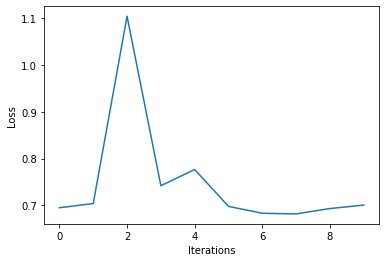

  0%|          | 10/2000 [00:38<2:06:35,  3.82s/it]


KeyboardInterrupt: 

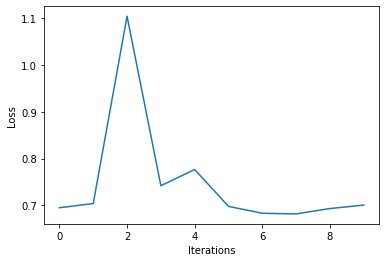

In [174]:
history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')

if hasattr(tqdm, '_instances'): tqdm._instances.clear()  # clear if it exists

for iter in tqdm(range(num_training_iterations)):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(reviews_encoded, labels, batch_size)
  loss = train_step(x_batch, y_batch)

  # Update the progress bar
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:     
    model.save_weights(checkpoint_prefix)
    
# Save the trained model and the weights
model.save_weights(checkpoint_prefix)